# The problem

Observed quantity: $F_\nu(\nu,t)$ at a number of points $(\nu_i,t_i)$ for $i=1,...,N$. To each observation (represented by the data vector $\vec d_i$) we can in principle associate a likelihood $p(\vec d_i\,|\,F_\nu)$. 

A model specifies a rest-frame $L_{\nu,\mathrm{m}}(\nu,t,\vec\theta')$, where $\vec\theta'$ is the vector of model parameters, and hence a flux $F_{\nu,\mathrm{m}}(\nu,t,\vec\theta) = (1+z)L_{\nu,\mathrm{m}}\left(\nu(1+z),t/(1+z),\vec\theta'\right)/4\pi d_\mathrm{L}^2$, where $\vec\theta=(\vec\theta',z,...)$ includes also the redshift and potentially the cosmological parameters needed to compute $d_\mathrm{L}$ from $z$.

Model fitting usually requires one to evaluaste the likelihoods of the data $p(\vec d_i\,|\,F_\nu)$ assuming the flux densities specified by the model are the "true" ones, $F_\nu=F_{\nu,\mathrm{m}}$, as a function of the model parameters $\vec\theta$, and use this to constrain the model parameter values. 

Here we work in a Bayesian framework and assume the measurements (and hence the likelihoods) to be independent. Using Bayes' theorem, the posterior probability on the model parameters is

$$
p\left (\vec\theta\,|\,\lbrace \vec d_i \rbrace_{i=1}^{N}\right) = p(\vec\theta) \prod_{i=1}^{N} \frac{p\left (\vec d_i \,|\, F_\mathrm{\nu,m}\left(\nu_i,t_i,\vec\theta\right)\right)}{p \left(\vec d_i\right)},
$$
where $p(\vec\theta)$ is the prior probability on the model parameters (which encodes any prior information we have, including the physically viable ranges of values) and $p(\lbrace \vec d_i \rbrace_{i=1}^{N})=\prod_{i=1}^{N} p(\vec d_i)$ is the "model evidence", that is, the overall probability of obtaining the dataset $\lbrace \vec d_i \rbrace_{i=1}^{N}$ if the model is correct. This is essentially the normalization of the posterior probability, it is a quantity of relevance in model selection, but it is often not easy to compute.

Most modern models have lots of parameters, so that the posterior probability density lives in a space with a high dimensionality, which is a technical complication in many cases. On the other hand, since we are typically interested in computing the *moments* of the posterior probability, such as the mean and standard deviation, we can be satisfied with a *Monte Carlo sampling* of the above probability, which would then enable Monte Carlo integrals. As an example, the mean of the posterior probability density
$$
\langle \vec\theta \rangle = \int \vec\theta\, p\left (\vec\theta\,|\,\lbrace \vec d_i \rbrace_{i=1}^{N}\right)\,\mathrm{d}\vec\theta
$$
can be approximated as
$$
\langle \vec\theta \rangle \sim \frac{1}{N}\sum_{j=1}^{N_\mathrm{s}} \vec\theta_j,
$$

where $\lbrace \vec\theta_j\rbrace_{j=1}^{N_\mathrm{s}}$ are posterior samples. This is a great simplification, because Monte Carlo sampling of a multi-dimensional probability distribution scales much better than computing it over a grid. 

In this tutorial, we will only cover sampling based on a Monte Carlo Markov Chain approach, but there are many (and in some cases much more efficient) methods. The most modern ones leverage upon machine learning methods to drastically reduce the likelihood evaluations, speeding up the way to the solution.


# The likelihoods in practice

To perform in practice the model fitting, we need to specify explicitly the above likelihoods. Ideally, one would like to have an exquisite characterization of the noise in the observation and a detailed model of the detector: that would allow for computing explicitly the likelihood $p(\vec d_i\,|\,F_\nu)$ as a function of $F_\nu$. In most cases relevant to us, though, this is either not feasible or too expensive. One then resorts to approximating the likelihoods in some way. 

A widely used approach is that of approximating the likelihoods as Gaussians (which is analogous to using chi squared statistics in a frequentist view). 

Since the Bayesian approach allows for a lot of flexibility, I personally use a slightly more refined approach which allows for (1) asymmetric errors and (2) upper- or lower-limits. The idea is that of using an asymmetric Gaussian of the form

\begin{equation}
p(\vec d_i\,|\,F_\nu) \propto \left\lbrace\begin{array}{lr}
                               \exp\left[-\frac{1}{2}\left(\frac{F_\nu-F_{\nu,0}}{\sigma_\mathrm{l}}\right)^2\right] & F_\nu\leq F_\mathrm{\nu,0}\\
                              \exp\left[-\frac{1}{2}\left(\frac{F_\nu-F_{\nu,0}}{\sigma_\mathrm{h}}\right)^2\right] & F_\nu> F_\mathrm{\nu,0}\\ 
                               \end{array}\right.,
\end{equation}

where $F_{\nu,0}$ is the "central" value of the flux density from the observation, $\sigma_\mathrm{l}$ is the "lower" one-sigma error and $\sigma_\mathrm{h}$ is the "upper" one-sigma error. Within this representation, upper limits can be approximated roughly by setting both $F_{\nu,0}$ and $\sigma_\mathrm{h}$ equal to the rms noise level and $\sigma_\mathrm{l}$ to infinity (in practice, a large value such as 10 times the rms noise). If the noise level is not available, one can just set $F_{\nu,0}$ equal to the formal upper limit value (at some confidence level), $\sigma_\mathrm{h}=\xi F_\mathrm{\nu,0}$ with $\xi\ll 1$ and again $\sigma_\mathrm{l}\to\infty$. This is rough, but it correctly represents the information that the flux density must not be larger than some value.

An issue with most data is that the reported uncertainties $\sigma_\mathrm{l}$, $\sigma_\mathrm{h}$ typically do not include the systematic contribution. This can be a big issue, as it can lead to paradoxical situations where datapoints at a similar time and frequency report flux densities which are incompatible with high confidence. From the inference point of view, this leads to a multi-modal posterior probability density with narrow peaks separated by large valleys, which is not good for most inference setups. To obviate to this, I usually include an unknown systematic error contribution to the reported uncertainties, which I parametrize as a fixed fraction of the "central" flux density from the measurement, i.e.
$$
\sigma_\mathrm{l} \to \sqrt{\sigma_\mathrm{l}^2+f_\mathrm{sys}^2 F_\mathrm{\nu,0}^2}
$$
and similarly for $\sigma_\mathrm{h}$. The parameter $f_\mathrm{sys}$ is assumed identical for all observations and fitted along with the others, with a log-uniform prior $p(f_\mathrm{sys})\propto f_\mathrm{sys}^{-1}$ for $10^{-5}<f_\mathrm{sys}<1$ (the lower limit is arbitrary, any small value would work), and then marginalized upon when producing the results.

The final assumed form of the log-likelihood of each datapoint is
$$
\ln p(\vec d_i\,|\,F_\nu) = -\frac{1}{2}\left(\frac{F_\nu-F_{\mathrm{\nu,0},i}}{\sqrt{\sigma_{i}^2(F_\nu)+f_\mathrm{sys}^2F_{\mathrm{\nu,0},i}^2}}\right)^2 - \ln\left[\sqrt{2\pi\left(\sigma_\mathrm{l}^2+f_\mathrm{sys}^2F_{\mathrm{\nu,0},i}^2\right)}+\sqrt{2\pi\left(\sigma_\mathrm{h}^2+f_\mathrm{sys}^2F_{\mathrm{\nu,0},i}^2\right)}\right]-\ln(1/2),
$$
where $\sigma_{i}(F_\nu)$ is either $\sigma_{\mathrm{l},i}$ or $\sigma_{\mathrm{h},i}$ depending on the sign of $F_\nu-F_{\mathrm{\nu,0},i}$, and the conventions to account for upper/lower limits are applied when appropriate. **Note that we have included the normalization**: this is needed because the normalization of the Gaussian is now a function of our $f_\mathrm{sys}$ parameter, and hence it cannot be omitted. The log posterior probability then becomes
$$
\ln p\left (\vec\theta,f_\mathrm{sys}\,|\,\lbrace \vec d_i \rbrace_{i=1}^{N}\right) = k + \ln p(\vec\theta) - \ln(f_\mathrm{sys}) - \frac{1}{2}  \sum_{i=1}^{N} \frac{\left(F_{\nu,\mathrm{m}}(\nu_i,t_i,\vec\theta)-F_{\mathrm{\nu,0},i}\right)^2}{\sigma_{i}^2(F_{\nu,\mathrm{m}}(\nu_i,t_i,\vec\theta))+f_\mathrm{sys}^2F_{\mathrm{\nu,0},i}^2} - {\sum_{i=1}^{N}\ln{\left[\sqrt{2\pi\left(\sigma_{\mathrm{l},i}^2+f_\mathrm{sys}^2F_{\mathrm{\nu,0},i}^2\right)}+\sqrt{2\pi\left(\sigma_{\mathrm{h},i}^2+f_\mathrm{sys}^2F_{\mathrm{\nu,0},i}^2\right)}\right]}},
$$
where $k$ is an unknown constant (which includes the evidence) and we explicitly included the log-uniform prior on $f_\mathrm{sys}$, $p(f_\mathrm{sys})\propto f_\mathrm{sys}^{-1}$ (which clearly favors lower values of $f_\mathrm{sys}$, hence "discouraging" the inference algorithm from inflating the systematic error to accommodate the model. 


### High energy flux datapoints

In multi-wavelength modelling, often one wants to include X-ray or higher-energy datapoints that typically consist of an integrated flux $F$ plus a photon index $\alpha$, such that $F_\nu\propto \nu^{1-\alpha}$ within the instrument band. There are two possible approaches: either these are converted to flux densities, so that the above approach can be applied, or an integrated flux and a photon index are extracted from the model. In the first case, one must keep in mind that the number of degrees of freedom must be conserved: hence, a pair $(F,\alpha)$ can be transformed into a pair of flux densities at some representative frequencies. Since it is not clear (to me) how to choose such frequencies, I usually go for the second option, i.e. computing the integrated flux and (average) photon index from the model. If the instrument band extends from $\nu_\mathrm{a}$ to $\nu_\mathrm{b}$, then
$$
F_\mathrm{m}(\nu_\mathrm{a},\nu_\mathrm{b},t,\vec\theta) = \int_{\nu_\mathrm{a}}^{\nu_\mathrm{b}} F_{\nu,\mathrm{m}}(\nu,t,\vec\theta)\,\mathrm{d}\nu
$$
and
$$
\alpha_\mathrm{m}(\nu_\mathrm{a},\nu_\mathrm{b},t,\vec\theta) = 1 - \frac{\int_{\nu_\mathrm{a}}^{\nu_\mathrm{b}} \left(\partial \ln F_{\nu,\mathrm{m}}(\nu,t,\vec\theta)/\partial \ln\nu\right)\,\mathrm{d}\nu}{\nu_\mathrm{b}-\nu_\mathrm{a}}.
$$
With these definitions, one can then use the same approach as above to define two asymmetric Gaussian likelihood terms per each flux measurement: one for the integrated flux and one for the photon index. **The inclusion of the photon index is an important piece of information, do not overlook this! I've seen blatantly wrong results obtained fitting X-ray data without including the photon index**.

# A practical example

Consider a scenario where we have multi-wavelength data that we interpret as the superposition of a kilonova and a GRB afterglow. If we want to extranct physical information on these sources through their light curves, we need to combine two physical models that predict their time-dependent specific luminosity as a function on their physical properties. The parametrization is very important, as it defines the dimensionality of the parameter space. If the model is plagued by inherent degeneracies, it may be convenient to reparametrize it to remove these degeneracies.

So, the first thing to do when we have some multi-wavelength data is to plot it, to get an idea. We're going to convert everything into flux densities here.

Text(0, 0.5, 'Flux density [mJy]')

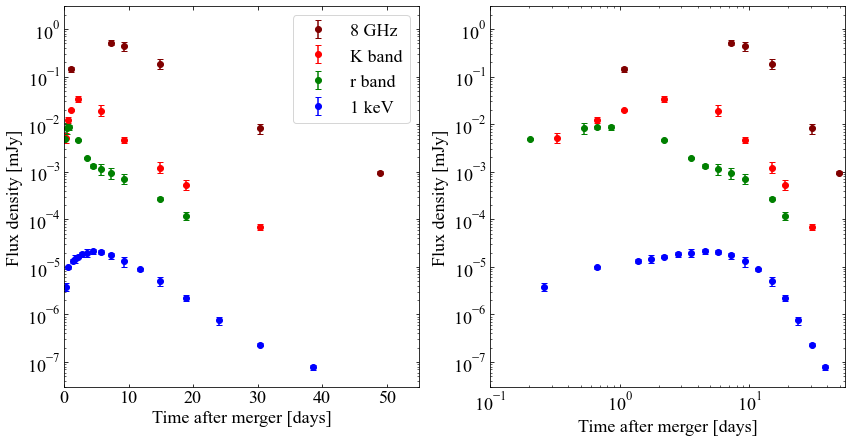

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import pandas

plt.rcParams['figure.figsize']=14,7
plt.rcParams['font.size']=18
plt.rcParams['font.family']='Times New Roman'
plt.rcParams['mathtext.fontset']='dejavuserif'


# load data
Radio = pandas.read_excel("../mock_data/Radio.ods")
IR = pandas.read_excel("../mock_data/NIR.ods")
Opt = pandas.read_excel("../mock_data/Optical.ods")
X = pandas.read_excel("../mock_data/X-rays.ods")

colors = ['maroon','r','g','b']

plt.subplot(121)

# plot Radio flux densities
plt.errorbar(Radio['t_days'],Radio['Fnu_mJy'],yerr=Radio['Fnu_err_mJy'],marker='o',ls='None',capsize=3,label='8 GHz',color=colors[0])

# compute and plot NIR and Optical flux densities
Fnuo = 3631*1e3*10**(-IR['AB_mag']/2.5)
Fnuo_l = 3631*1e3*10**(-(IR['AB_mag']+IR['AB_mag_err'])/2.5)
Fnuo_h = 3631*1e3*10**(-(IR['AB_mag']-IR['AB_mag_err'])/2.5)
plt.errorbar(IR['t_days'],Fnuo,yerr=(Fnuo-Fnuo_l,Fnuo_h-Fnuo),marker='o',ls='None',capsize=3,label='K band',color=colors[1])

Fnuo = 3631*1e3*10**(-Opt['AB_mag']/2.5)
Fnuo_l = 3631*1e3*10**(-(Opt['AB_mag']+Opt['AB_mag_err'])/2.5)
Fnuo_h = 3631*1e3*10**(-(Opt['AB_mag']-Opt['AB_mag_err'])/2.5)
plt.errorbar(Opt['t_days'],Fnuo,yerr=(Fnuo-Fnuo_l,Fnuo_h-Fnuo),marker='o',ls='None',capsize=3,label='r band',color=colors[2])

# compute and plot X-ray flux densities
nua = 0.3*2.4e17
nub = 10.*2.4e17
nuX = 2.4e17
Fnuo = (2.-X['ph_index'])*X['Flux_cgs']/(nub**(2.-X['ph_index'])-nua**(2.-X['ph_index']))*nuX**(1.-X['ph_index'])*1e26
Fnuo_err = Fnuo*X['Flux_cgs_err']/X['Flux_cgs']

plt.errorbar(X['t_days'],Fnuo,yerr=Fnuo_err,marker='o',ls='None',capsize=3,label='1 keV',color=colors[3])

plt.semilogy()
plt.tick_params(which='both',direction='in',top=True,right=True)

plt.xlim(0.,55)
plt.ylim(3e-8,3e0)

plt.legend()

plt.xlabel(r'Time after merger [days]')
plt.ylabel(r'Flux density [mJy]')

plt.subplot(122)

# plot Radio flux densities
plt.errorbar(Radio['t_days'],Radio['Fnu_mJy'],yerr=Radio['Fnu_err_mJy'],marker='o',ls='None',capsize=3,label='8 GHz',color=colors[0])

# compute and plot NIR and Optical flux densities
Fnuo = 3631*1e3*10**(-IR['AB_mag']/2.5)
Fnuo_l = 3631*1e3*10**(-(IR['AB_mag']+IR['AB_mag_err'])/2.5)
Fnuo_h = 3631*1e3*10**(-(IR['AB_mag']-IR['AB_mag_err'])/2.5)
plt.errorbar(IR['t_days'],Fnuo,yerr=(Fnuo-Fnuo_l,Fnuo_h-Fnuo),marker='o',ls='None',capsize=3,label='K band',color=colors[1])

Fnuo = 3631*1e3*10**(-Opt['AB_mag']/2.5)
Fnuo_l = 3631*1e3*10**(-(Opt['AB_mag']+Opt['AB_mag_err'])/2.5)
Fnuo_h = 3631*1e3*10**(-(Opt['AB_mag']-Opt['AB_mag_err'])/2.5)
plt.errorbar(Opt['t_days'],Fnuo,yerr=(Fnuo-Fnuo_l,Fnuo_h-Fnuo),marker='o',ls='None',capsize=3,label='r band',color=colors[2])

# compute and plot X-ray flux densities
nua = 0.3*2.4e17
nub = 10.*2.4e17
nuX = 2.4e17
Fnuo = (2.-X['ph_index'])*X['Flux_cgs']/(nub**(2.-X['ph_index'])-nua**(2.-X['ph_index']))*nuX**(1.-X['ph_index'])*1e26
Fnuo_err = Fnuo*X['Flux_cgs_err']/X['Flux_cgs']

plt.errorbar(X['t_days'],Fnuo,yerr=Fnuo_err,marker='o',ls='None',capsize=3,label='1 keV',color=colors[3])

plt.loglog()
plt.tick_params(which='both',direction='in',top=True,right=True)

plt.xlim(0.1,55)
plt.ylim(3e-8,3e0)

#plt.legend()

plt.xlabel(r'Time after merger [days]')
plt.ylabel(r'Flux density [mJy]')


This looks pretty interesting. The X-rays and radio seem to track each other quite well. This is suggestive of a broadband synchrotron component. The fact that it peaks at several days points to an off-axis jet. The IR and Optical seem to behave differently: the IR is clearly peaking at a much earlier time, while the Optical shows a hint of a double peak. Let's first of all try to model the X-rays and radio with an off-axis jet model. We'll use afterglowpy, which is useful when the viewing angle is relatively large.

Text(0, 0.5, 'Flux density [mJy]')

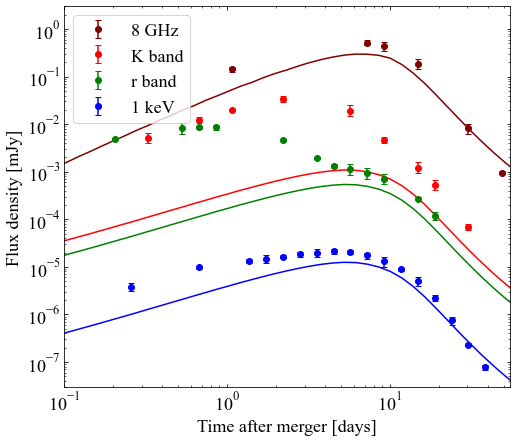

In [85]:
from astropy.cosmology import Planck18 as cosmo
import afterglowpy as agpy

plt.rcParams['figure.figsize']=8,7

# we know the redshift!
z = 0.025
dL = cosmo.luminosity_distance(z).to('cm').value

# set model parameters
E = 1e52
n = 0.01
thj = 0.035
ee = 0.1
eB = 0.001
p = 2.2
thv = 0.2

# evaluate model
Z = {'jetType':agpy.jet.Gaussian,'specType':0,'thetaObs':thv,'E0':E,'n0':n,
     'thetaCore':thj,'thetaWing':5*thj,'epsilon_e':ee,'epsilon_B':eB,'p':p,
     'xi_N':1.,'d_L':dL,'z':z,'spread':True,'g0':167,'b':8.}

num = np.array([8e9,1.4e14,4.5e14,2.4e17])
tm = np.logspace(0,7,100)

tmg,numg = np.meshgrid(tm,num)

dFdnu_FS = agpy.fluxDensity(tmg.ravel(),numg.ravel(),**Z).reshape([len(num),len(tm)])

# plot it
for i in range(len(num)):
    plt.plot(tm/86400.,dFdnu_FS[i],color=colors[i])

# --------------- then plot the data on top -------------
    
# plot Radio flux densities
plt.errorbar(Radio['t_days'],Radio['Fnu_mJy'],yerr=Radio['Fnu_err_mJy'],marker='o',ls='None',capsize=3,label='8 GHz',color=colors[0])

# compute and plot NIR and Optical flux densities
Fnuo = 3631*1e3*10**(-IR['AB_mag']/2.5)
Fnuo_l = 3631*1e3*10**(-(IR['AB_mag']+IR['AB_mag_err'])/2.5)
Fnuo_h = 3631*1e3*10**(-(IR['AB_mag']-IR['AB_mag_err'])/2.5)
plt.errorbar(IR['t_days'],Fnuo,yerr=(Fnuo-Fnuo_l,Fnuo_h-Fnuo),marker='o',ls='None',capsize=3,label='K band',color=colors[1])

Fnuo = 3631*1e3*10**(-Opt['AB_mag']/2.5)
Fnuo_l = 3631*1e3*10**(-(Opt['AB_mag']+Opt['AB_mag_err'])/2.5)
Fnuo_h = 3631*1e3*10**(-(Opt['AB_mag']-Opt['AB_mag_err'])/2.5)
plt.errorbar(Opt['t_days'],Fnuo,yerr=(Fnuo-Fnuo_l,Fnuo_h-Fnuo),marker='o',ls='None',capsize=3,label='r band',color=colors[2])

# compute and plot X-ray flux densities
nua = 0.3*2.4e17
nub = 10.*2.4e17
nuX = 2.4e17
Fnuo = (2.-X['ph_index'])*X['Flux_cgs']/(nub**(2.-X['ph_index'])-nua**(2.-X['ph_index']))*nuX**(1.-X['ph_index'])*1e26
Fnuo_err = Fnuo*X['Flux_cgs_err']/X['Flux_cgs']

plt.errorbar(X['t_days'],Fnuo,yerr=Fnuo_err,marker='o',ls='None',capsize=3,label='1 keV',color=colors[3])

plt.loglog()

plt.xlim(1e-1,55)
plt.ylim(3e-8,3e0)

plt.legend()
plt.tick_params(which='both',direction='in',top=True,right=True)


plt.xlabel(r'Time after merger [days]')
plt.ylabel(r'Flux density [mJy]')


Let's also look at the spectra, to get more guidance (remember we have X-ray photon indices!)

Text(0, 0.5, 'Flux density [mJy]')

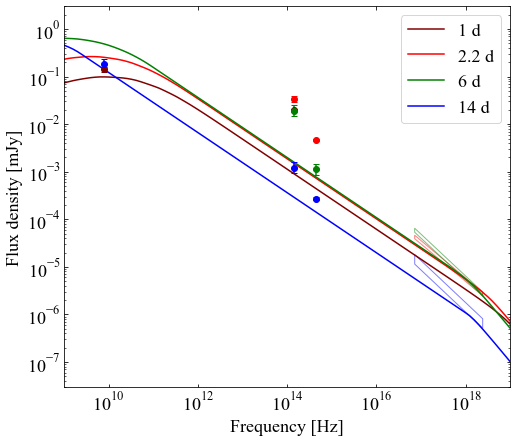

In [214]:

# selected times when we have good spectral coverage
t_spec = np.array([1.,2.2,6.,14.])
dlogt = np.array([0.1,0.1,0.1,0.1]) # time bin width (in log)

num = np.logspace(9,19,100)
tm = t_spec*86400.
tmg,numg = np.meshgrid(tm,num)


# plot it
for i in range(len(t_spec)):
    plt.plot(num,dFdnu_FS[:,i],color=colors[i],label='{0:.2g} d'.format(t_spec[i]))

# --------------- then plot the data on top -------------
    
    # plot Radio flux densities
    sel = np.abs(np.log(Radio['t_days']/(t_spec[i])))<dlogt[i]
    plt.errorbar(np.ones(len(Radio))[sel]*8e9,Radio.loc[sel,'Fnu_mJy'],yerr=Radio.loc[sel,'Fnu_err_mJy'],marker='o',ls='None',capsize=3,color=colors[i])

    # compute and plot NIR and Optical flux densities
    sel = np.abs(np.log(IR['t_days']/(t_spec[i])))<dlogt[i]
    Fnuo = 3631*1e3*10**(-IR.loc[sel,'AB_mag']/2.5)
    Fnuo_l = 3631*1e3*10**(-(IR.loc[sel,'AB_mag']+IR.loc[sel,'AB_mag_err'])/2.5)
    Fnuo_h = 3631*1e3*10**(-(IR.loc[sel,'AB_mag']-IR.loc[sel,'AB_mag_err'])/2.5)
    plt.errorbar(np.ones(len(Fnuo))*1.4e14,Fnuo,yerr=(Fnuo-Fnuo_l,Fnuo_h-Fnuo),marker='o',ls='None',capsize=3,color=colors[i])
    
    sel = np.abs(np.log(Opt['t_days']/(t_spec[i])))<dlogt[i]
    Fnuo = 3631*1e3*10**(-Opt.loc[sel,'AB_mag']/2.5)
    Fnuo_l = 3631*1e3*10**(-(Opt.loc[sel,'AB_mag']+Opt.loc[sel,'AB_mag_err'])/2.5)
    Fnuo_h = 3631*1e3*10**(-(Opt.loc[sel,'AB_mag']-Opt.loc[sel,'AB_mag_err'])/2.5)
    plt.errorbar(np.ones(len(Fnuo))*4.5e14,Fnuo,yerr=(Fnuo-Fnuo_l,Fnuo_h-Fnuo),marker='o',ls='None',capsize=3,color=colors[i])

    # compute and plot X-ray flux densities
    nua = 0.3*2.4e17
    nub = 10.*2.4e17
    nuX = np.logspace(np.log10(0.3),1.,30)*2.4e17
    nuX = nuX.reshape([30,1])
    sel = np.abs(np.log(X['t_days']/(t_spec[i])))<dlogt[i]
    if np.sum(sel)>0:
        Fnuo = (2.-X.loc[sel,'ph_index'])*X.loc[sel,'Flux_cgs']/(nub**(2.-X.loc[sel,'ph_index'])-nua**(2.-X.loc[sel,'ph_index']))*1e26
        Fnuo = Fnuo.values[:,None]*(nuX**(1.-X.loc[sel,'ph_index'].values))
        Fnuo_err = Fnuo*(X.loc[sel,'Flux_cgs_err'].values/X.loc[sel,'Flux_cgs'].values)
        
        for k in range(Fnuo.shape[1]):
            plt.fill_between(nuX[:,0],Fnuo[:,k]-Fnuo_err[:,k],Fnuo[:,k]+Fnuo_err[:,k],ls='-',edgecolor=colors[i],facecolor='None',alpha=0.5)

plt.loglog()

plt.xlim(1e9,1e19)
plt.ylim(3e-8,3e0)

plt.legend()
plt.tick_params(which='both',direction='in',top=True,right=True)


plt.xlabel(r'Frequency [Hz]')
plt.ylabel(r'Flux density [mJy]')


After some trial and error, not without guidance from theoretical prejudice, apparently we found a pretty nice parameter set. If this is correct, then there seems to be an additional component that dominates the IR and the early Optical. Let's try to model it with a super simplified kilonova model.

In [81]:
c = 3e10 # cm/s -- speed of light
h = 6.626e-27 #erg s -- Planck's constant
kB = 1.38e-16 #erg K-1 -- Boltzmann's constant
sigma_SB = 5.67e-5 #erg/s/cm2/K4 -- Stephan-Boltzmann's constant
K = 15.*(h/kB)**4/4./np.pi**5 #convenience constant

def BBnu(nuobs,L,Teff,dL,z): # Blackbody spectrum
    return K * (1.+z)**4/dL**2 * L/Teff**4 * nuobs**3/(np.exp((1.+z)*h*nuobs/kB/Teff)-1.)

def simplistic_kilonova(nu,t,Mej,vej,k):
    L_heat = 2e33*Mej*2e18*(0.5-np.pi**-1*np.arctan((t-1.3)/0.11))**1.3 # Korobkin+12
    tdiff = np.sqrt(k*2e33*Mej/(4*np.pi*vej*c**2)) # effective diffusion time
    L = L_heat*np.minimum(t/tdiff,1.)**2 # super simplistic radiative transfer
    R = vej*c*t # fixed photosphere in lagrangian coordinates
    T = (L/(4*np.pi*sigma_SB*R**2))**0.25 # effective temperature
    
    return BBnu(nu,L,T,dL,z)*1e26 # to mJy

/tmp/ipykernel_11589/2602178814.py:8: RuntimeWarning: overflow encountered in exp
  return K * (1.+z)**4/dL**2 * L/Teff**4 * nuobs**3/(np.exp((1.+z)*h*nuobs/kB/Teff)-1.)


Text(0, 0.5, 'Flux density [mJy]')

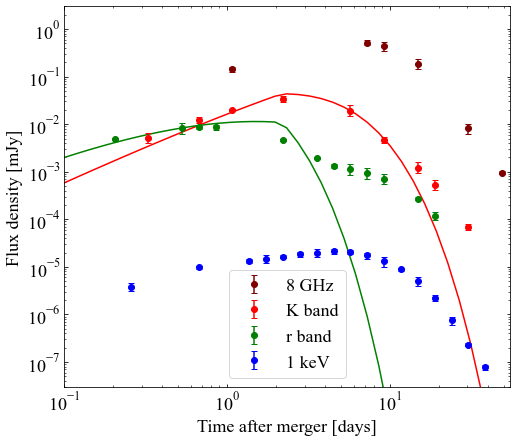

In [82]:
# kilonova model parameters
Mej = 0.03
vej = 0.3
k = 2.

# evaluate model
dFdnu_KN = simplistic_kilonova(numg.ravel(),tmg.ravel(),Mej,vej,k).reshape([len(num),len(tm)])
# plot it
for i in range(len(num)):
    plt.plot(tm/86400.,dFdnu_KN[i],color=colors[i])

# --------------- then plot the data on top -------------
    
# plot Radio flux densities
plt.errorbar(Radio['t_days'],Radio['Fnu_mJy'],yerr=Radio['Fnu_err_mJy'],marker='o',ls='None',capsize=3,label='8 GHz',color=colors[0])

# compute and plot NIR and Optical flux densities
Fnuo = 3631*1e3*10**(-IR['AB_mag']/2.5)
Fnuo_l = 3631*1e3*10**(-(IR['AB_mag']+IR['AB_mag_err'])/2.5)
Fnuo_h = 3631*1e3*10**(-(IR['AB_mag']-IR['AB_mag_err'])/2.5)
plt.errorbar(IR['t_days'],Fnuo,yerr=(Fnuo-Fnuo_l,Fnuo_h-Fnuo),marker='o',ls='None',capsize=3,label='K band',color=colors[1])

Fnuo = 3631*1e3*10**(-Opt['AB_mag']/2.5)
Fnuo_l = 3631*1e3*10**(-(Opt['AB_mag']+Opt['AB_mag_err'])/2.5)
Fnuo_h = 3631*1e3*10**(-(Opt['AB_mag']-Opt['AB_mag_err'])/2.5)
plt.errorbar(Opt['t_days'],Fnuo,yerr=(Fnuo-Fnuo_l,Fnuo_h-Fnuo),marker='o',ls='None',capsize=3,label='r band',color=colors[2])

# compute and plot X-ray flux densities
nua = 0.3*2.4e17
nub = 10.*2.4e17
nuX = 2.4e17
Fnuo = (2.-X['ph_index'])*X['Flux_cgs']/(nub**(2.-X['ph_index'])-nua**(2.-X['ph_index']))*nuX**(1.-X['ph_index'])*1e26
Fnuo_err = Fnuo*X['Flux_cgs_err']/X['Flux_cgs']

plt.errorbar(X['t_days'],Fnuo,yerr=Fnuo_err,marker='o',ls='None',capsize=3,label='1 keV',color=colors[3])

plt.loglog()

plt.xlim(1e-1,55)
plt.ylim(3e-8,3e0)

plt.legend()
plt.tick_params(which='both',direction='in',top=True,right=True)


plt.xlabel(r'Time after merger [days]')
plt.ylabel(r'Flux density [mJy]')


That looks pretty nice! Let's plot the two components together!

Text(0, 0.5, 'Flux density [mJy]')

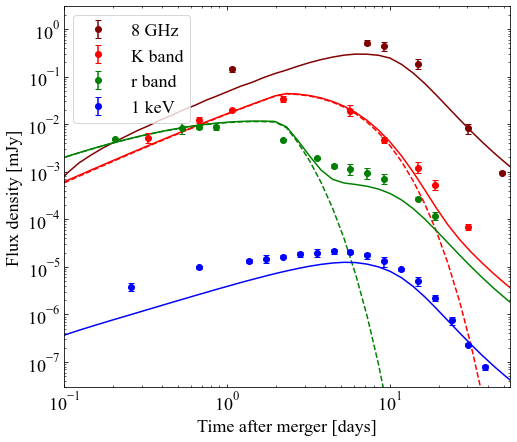

In [83]:
# plot it
for i in range(len(num)):
    plt.plot(tm/86400.,dFdnu_KN[i]+dFdnu_FS[i],color=colors[i],ls='-')
    plt.plot(tm/86400.,dFdnu_KN[i],color=colors[i],ls='--')

# --------------- then plot the data on top -------------
    
# plot Radio flux densities
plt.errorbar(Radio['t_days'],Radio['Fnu_mJy'],yerr=Radio['Fnu_err_mJy'],marker='o',ls='None',capsize=3,label='8 GHz',color=colors[0])

# compute and plot NIR and Optical flux densities
Fnuo = 3631*1e3*10**(-IR['AB_mag']/2.5)
Fnuo_l = 3631*1e3*10**(-(IR['AB_mag']+IR['AB_mag_err'])/2.5)
Fnuo_h = 3631*1e3*10**(-(IR['AB_mag']-IR['AB_mag_err'])/2.5)
plt.errorbar(IR['t_days'],Fnuo,yerr=(Fnuo-Fnuo_l,Fnuo_h-Fnuo),marker='o',ls='None',capsize=3,label='K band',color=colors[1])

Fnuo = 3631*1e3*10**(-Opt['AB_mag']/2.5)
Fnuo_l = 3631*1e3*10**(-(Opt['AB_mag']+Opt['AB_mag_err'])/2.5)
Fnuo_h = 3631*1e3*10**(-(Opt['AB_mag']-Opt['AB_mag_err'])/2.5)
plt.errorbar(Opt['t_days'],Fnuo,yerr=(Fnuo-Fnuo_l,Fnuo_h-Fnuo),marker='o',ls='None',capsize=3,label='r band',color=colors[2])

# compute and plot X-ray flux densities
nua = 0.3*2.4e17
nub = 10.*2.4e17
nuX = 2.4e17
Fnuo = (2.-X['ph_index'])*X['Flux_cgs']/(nub**(2.-X['ph_index'])-nua**(2.-X['ph_index']))*nuX**(1.-X['ph_index'])*1e26
Fnuo_err = Fnuo*X['Flux_cgs_err']/X['Flux_cgs']

plt.errorbar(X['t_days'],Fnuo,yerr=Fnuo_err,marker='o',ls='None',capsize=3,label='1 keV',color=colors[3])

plt.loglog()

plt.xlim(1e-1,55)
plt.ylim(3e-8,3e0)

plt.legend()
plt.tick_params(which='both',direction='in',top=True,right=True)


plt.xlabel(r'Time after merger [days]')
plt.ylabel(r'Flux density [mJy]')


/tmp/ipykernel_11589/2602178814.py:13: RuntimeWarning: divide by zero encountered in divide
  L = L_heat*np.minimum(t/tdiff,1.)**2 # super simplistic radiative transfer
/tmp/ipykernel_11589/2602178814.py:8: RuntimeWarning: overflow encountered in exp
  return K * (1.+z)**4/dL**2 * L/Teff**4 * nuobs**3/(np.exp((1.+z)*h*nuobs/kB/Teff)-1.)


Text(0, 0.5, 'Flux density [mJy]')

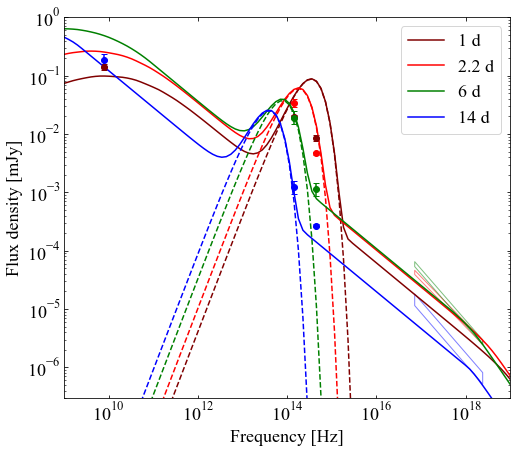

In [212]:

# selected times when we have good spectral coverage
t_spec = np.array([1.,2.2,6.,14.])
dlogt = np.array([0.2,0.2,0.1,0.1]) # time bin width (in log)

num = np.logspace(9,19,100)
tm = t_spec*86400.
tmg,numg = np.meshgrid(tm,num)


dFdnu_KN = simplistic_kilonova(numg.ravel(),tmg.ravel(),Mej,vej,k).reshape([len(num),len(tm)])

# plot it
for i in range(len(t_spec)):
    plt.plot(num,dFdnu_FS[:,i]+dFdnu_KN[:,i],color=colors[i],label='{0:.2g} d'.format(t_spec[i]))
    plt.plot(num,dFdnu_KN[:,i],ls='--',color=colors[i])

# --------------- then plot the data on top -------------
    
    # plot Radio flux densities
    sel = np.abs(np.log(Radio['t_days']/(t_spec[i])))<dlogt[i]
    plt.errorbar(np.ones(len(Radio))[sel]*8e9,Radio.loc[sel,'Fnu_mJy'],yerr=Radio.loc[sel,'Fnu_err_mJy'],marker='o',ls='None',capsize=3,color=colors[i])

    # compute and plot NIR and Optical flux densities
    sel = np.abs(np.log(IR['t_days']/(t_spec[i])))<dlogt[i]
    Fnuo = 3631*1e3*10**(-IR.loc[sel,'AB_mag']/2.5)
    Fnuo_l = 3631*1e3*10**(-(IR.loc[sel,'AB_mag']+IR.loc[sel,'AB_mag_err'])/2.5)
    Fnuo_h = 3631*1e3*10**(-(IR.loc[sel,'AB_mag']-IR.loc[sel,'AB_mag_err'])/2.5)
    plt.errorbar(np.ones(len(Fnuo))*1.4e14,Fnuo,yerr=(Fnuo-Fnuo_l,Fnuo_h-Fnuo),marker='o',ls='None',capsize=3,color=colors[i])
    
    sel = np.abs(np.log(Opt['t_days']/(t_spec[i])))<dlogt[i]
    Fnuo = 3631*1e3*10**(-Opt.loc[sel,'AB_mag']/2.5)
    Fnuo_l = 3631*1e3*10**(-(Opt.loc[sel,'AB_mag']+Opt.loc[sel,'AB_mag_err'])/2.5)
    Fnuo_h = 3631*1e3*10**(-(Opt.loc[sel,'AB_mag']-Opt.loc[sel,'AB_mag_err'])/2.5)
    plt.errorbar(np.ones(len(Fnuo))*4.5e14,Fnuo,yerr=(Fnuo-Fnuo_l,Fnuo_h-Fnuo),marker='o',ls='None',capsize=3,color=colors[i])

    # compute and plot X-ray flux densities
    nua = 0.3*2.4e17
    nub = 10.*2.4e17
    nuX = np.logspace(np.log10(0.3),1.,30)*2.4e17
    nuX = nuX.reshape([30,1])
    sel = np.abs(np.log(X['t_days']/(t_spec[i])))<dlogt[i]
    if np.sum(sel)>0:
        Fnuo = (2.-X.loc[sel,'ph_index'])*X.loc[sel,'Flux_cgs']/(nub**(2.-X.loc[sel,'ph_index'])-nua**(2.-X.loc[sel,'ph_index']))*1e26
        Fnuo = Fnuo.values[:,None]*(nuX**(1.-X.loc[sel,'ph_index'].values))
        Fnuo_err = Fnuo*(X.loc[sel,'Flux_cgs_err'].values/X.loc[sel,'Flux_cgs'].values)
        
        for k in range(Fnuo.shape[1]):
            plt.fill_between(nuX[:,0],Fnuo[:,k]-Fnuo_err[:,k],Fnuo[:,k]+Fnuo_err[:,k],ls='-',edgecolor=colors[i],facecolor='None',alpha=0.5)

plt.loglog()

plt.xlim(1e9,1e19)
plt.ylim(3e-7,1e0)

plt.legend()
plt.tick_params(which='both',direction='in',top=True,right=True)


plt.xlabel(r'Frequency [Hz]')
plt.ylabel(r'Flux density [mJy]')


This looks convincing! This is going to be the starting point for our fitting. We need to implement the posterior probability evaluation, use the above parameters as our initial conditions and then run an MCMC sampler to find the posterior samples. Note that the effective prior depends on the parametrization chosen: if not specified, the prior is flat in the chosen parameter.

In [131]:
def logprob(x):
    E = 10**x[0] # effectively log-uniform prior
    n = 10**x[1] # effectively log-uniform prior
    thj = x[2] 
    ee = 0.1
    eB = 10**x[3] # effectively log-uniform prior
    p = x[4]
    thv = x[5] # isotropic prior
    Mej = 10**x[6] # effectively log-uniform prior
    vej = x[7]
    k = x[8]
    fsys = 10**x[9] # effectively log-uniform prior
    
    # boundaries
    if E<1e49 or E>1e54\
    or n<1e-6 or n>1e2\
    or thj<0.01 or thj>(np.pi/10.)\
    or eB<1e-6 or eB>0.5\
    or p<2.01 or p>2.99\
    or thv<0. or thv>(np.pi/2.)\
    or Mej<1e-5 or Mej>0.2\
    or vej<0.01 or vej>0.6\
    or k<0.1 or k>100.\
    or fsys<1e-5 or fsys>1.:
        return -np.inf
    
    
    # Radio
    Fnu0i = Radio['Fnu_mJy']
    sigma_li = Radio['Fnu_err_mJy']
    sigma_hi = Radio['Fnu_err_mJy']
    nui = np.ones(len(Fnu0i))*8e9
    ti = Radio['t_days']*86400.
    
    # evaluate model
    Z = {'jetType':agpy.jet.Gaussian,'specType':0,'thetaObs':thv,'E0':E,'n0':n,
     'thetaCore':thj,'thetaWing':5*thj,'epsilon_e':ee,'epsilon_B':eB,'p':p,
     'xi_N':1.,'d_L':dL,'z':z,'spread':True}

    Fnu_FS_i = agpy.fluxDensity(ti,nui,**Z)
    #Fnu_KN_i = simplistic_kilonova(nui,ti,Mej,vej,k)
    
    Fnumi = np.nan_to_num(Fnu_FS_i) #+ np.nan_to_num(Fnu_KN_i)
    
    # evaluate logprobability
    sigmai = np.where(Fnumi<Fnu0i,sigma_li,sigma_hi)
    logp = -0.5*np.sum((Fnumi-Fnu0i)**2/(sigmai**2+fsys**2*Fnu0i**2))-\
    np.sum(np.log(np.sqrt(2*np.pi*(sigma_li**2+fsys**2*Fnu0i**2))+\
                  np.sqrt(2*np.pi*(sigma_hi**2+fsys**2*Fnu0i**2))))
    
    
    
    # NIR
    Fnu0i = 3631*1e3*10**(-IR['AB_mag']/2.5)
    Fnu0_l = 3631*1e3*10**(-(IR['AB_mag']+IR['AB_mag_err'])/2.5)
    Fnu0_h = 3631*1e3*10**(-(IR['AB_mag']-IR['AB_mag_err'])/2.5)
    sigma_li = Fnu0i-Fnu0_l
    sigma_hi = -Fnu0i+Fnu0_h
    
    nui = np.ones(len(Fnu0i))*1.4e14
    ti = IR['t_days']*86400.
    
    # evaluate model
    Fnu_FS_i = agpy.fluxDensity(ti,nui,**Z)
    Fnu_KN_i = simplistic_kilonova(nui,ti,Mej,vej,k)
    
    Fnumi = np.nan_to_num(Fnu_FS_i) + np.nan_to_num(Fnu_KN_i)
    
    # evaluate logprobability
    sigmai = np.where(Fnumi<Fnu0i,sigma_li,sigma_hi)
    logp += -0.5*np.sum((Fnumi-Fnu0i)**2/(sigmai**2+fsys**2*Fnu0i**2))-\
    np.sum(np.log(np.sqrt(2*np.pi*(sigma_li**2+fsys**2*Fnu0i**2))+\
                  np.sqrt(2*np.pi*(sigma_hi**2+fsys**2*Fnu0i**2))))

    
    # Optical
    Fnu0i = 3631*1e3*10**(-Opt['AB_mag']/2.5)
    Fnu0_l = 3631*1e3*10**(-(Opt['AB_mag']+Opt['AB_mag_err'])/2.5)
    Fnu0_h = 3631*1e3*10**(-(Opt['AB_mag']-Opt['AB_mag_err'])/2.5)
    sigma_li = Fnu0i-Fnu0_l
    sigma_hi = -Fnu0i+Fnu0_h
    
    nui = np.ones(len(Fnu0i))*4.5e14
    ti = Opt['t_days']*86400.
    
    # evaluate model
    Fnu_FS_i = agpy.fluxDensity(ti,nui,**Z)
    Fnu_KN_i = simplistic_kilonova(nui,ti,Mej,vej,k)
    
    Fnumi = np.nan_to_num(Fnu_FS_i) + np.nan_to_num(Fnu_KN_i)
    
    # evaluate logprobability
    sigmai = np.where(Fnumi<Fnu0i,sigma_li,sigma_hi)
    logp += -0.5*np.sum((Fnumi-Fnu0i)**2/(sigmai**2+fsys**2*Fnu0i**2))-\
    np.sum(np.log(np.sqrt(2*np.pi*(sigma_li**2+fsys**2*Fnu0i**2))+\
                  np.sqrt(2*np.pi*(sigma_hi**2+fsys**2*Fnu0i**2))))

    #X-rays
    Fi = X['Flux_cgs']
    Fi_err_low = X['Flux_cgs_err']
    Fi_err_high = X['Flux_cgs_err']
    alphai = X['ph_index']
    alphai_err_low = X['ph_index_err']
    alphai_err_high = X['ph_index_err']
    
    nuX = np.linspace(0.3,10,5)*2.4e17 # 0.3-10 keV
    ti = X['t_days']*86400.
    nui,ti = np.broadcast_arrays(nuX[:,None],ti)
    
    # evaluate model
    dFdnu_FS_X = agpy.fluxDensity(ti.ravel(),nui.ravel(),**Z).reshape(nui.shape)
    FXmi = np.trapz(dFdnu_FS_X*1e-26,nuX,axis=0) # 1e-26 is mJy to cgs
    alphami = 1.-np.trapz(np.gradient(np.log(dFdnu_FS_X),np.log(nuX),axis=0),nuX,axis=0)/(nuX[-1]-nuX[0])
    
    # evaluate logprobability
    ## Flux
    sigmai = np.where(FXmi<Fi,Fi_err_low,Fi_err_high)
    logp += -0.5*np.sum((FXmi-Fi)**2/(sigmai**2+fsys**2*Fi**2))-\
    np.sum(np.log(np.sqrt(2*np.pi*(Fi_err_low**2+fsys**2*Fi**2))+\
                  np.sqrt(2*np.pi*(Fi_err_high**2+fsys**2*Fi**2))))

    ## photon index
    sigmai = np.where(alphami<alphai,alphai_err_low,alphai_err_high)
    logp += -0.5*np.sum((alphami-alphai)**2/(sigmai**2+fsys**2*alphai**2))-\
    np.sum(np.log(np.sqrt(2*np.pi*(alphai_err_low**2+fsys**2*alphai**2))+\
                  np.sqrt(2*np.pi*(alphai_err_high**2+fsys**2*alphai**2))))
    
    return logp

In [132]:
E = 1e52
n = 0.01
thj = 0.035
ee = 0.1
eB = 0.001
p = 2.2
thv = 0.2
Mej = 0.03
vej = 0.3
k = 2.
fsys=0.01

logprob([np.log10(E),np.log10(n),thj,np.log10(eB),p,thv,np.log10(Mej),vej,k,np.log10(fsys)])

140.51796641349353

In [133]:
import emcee
from multiprocessing import Pool

# initial condition
x0 = np.array([np.log10(E),np.log10(n),thj,np.log10(eB),p,thv,np.log10(Mej),vej,k,np.log10(fsys)])

ndim = len(x0) # dimensionality of param space
nwalkers = 4*ndim # number of walkers (typically even number * ndim)

x0w = (1.+np.random.normal(0.,1e-4,[nwalkers,ndim]))*x0 # initial conditions of walkers (randomized around our guess)

# check that all logrpobs are finite
for i in range(nwalkers):
    print(logprob(x0w[i]))

153.99155156889867
149.26839620486476
139.82717574490263
142.88958149369853
125.90610465570533
117.99460498799637
143.66985018608764
136.93209470126897
133.25163980754598
137.31471558095706
126.47233879799614
132.80521196000888
161.14633960487726
150.71972196660172
141.30877628511666
147.50297091056265
138.32746479255832
145.2856670808923
157.04819062381702
151.68776192750542
135.91035330330163
117.05639236461046
146.1216969426101
122.32331924235517
142.58511173543894
147.52607672256232
140.52743631840872
140.42380923953993
142.7948061366712
138.95119053460954
143.48172796939804
123.40501643728598
142.80181432196449
130.12910152936166
150.0134047384845
141.08851499942998
136.03232153298765
131.2369146676065
134.52018710102797
129.2869758764651


In [162]:
nsteps = 10000 # number of MCMC iterations desired (on my laptop, using 6 cores, it takes 6-7 hours to complete 10000)
       
filename = "chain0.h5"
backend = emcee.backends.HDFBackend(filename) # this saves the chain to an hdf5 file, which can be 
       
#backend.reset(nwalkers,ndim)

with Pool(10) as pool:
    sampler = emcee.EnsembleSampler(nwalkers,ndim,logprob,backend=backend,pool=pool)
    if sampler.iteration>0:
        sampler.run_mcmc(None,nsteps-sampler.iteration,progress=True) # check whether the chain is restarted
    else:
        sampler.run_mcmc(x0w,nsteps,progress=True)

0it [00:00, ?it/s]


One way to tell whether the result is "converged" is to look at the auto-correlation length of the chain, averaged over the dimensions. The chain is starting to converge when the auto-correlation length falls to below ~2% of the chain length. As this may be difficult to achieve due to computational cost, one can get away with several percent, but it must be strictly below 10%, because for autocorrelations of 10% of longer `emcee` is unable to compute it reliably.

In [163]:
autocorr_length = np.mean(backend.get_autocorr_time(tol=0.))

print('Autocorrelation length is approximately {0:.0f} percent of the chain length.'.format(100*autocorr_length/backend.iteration))

Autocorrelation length is approximately 4 percent of the chain length.


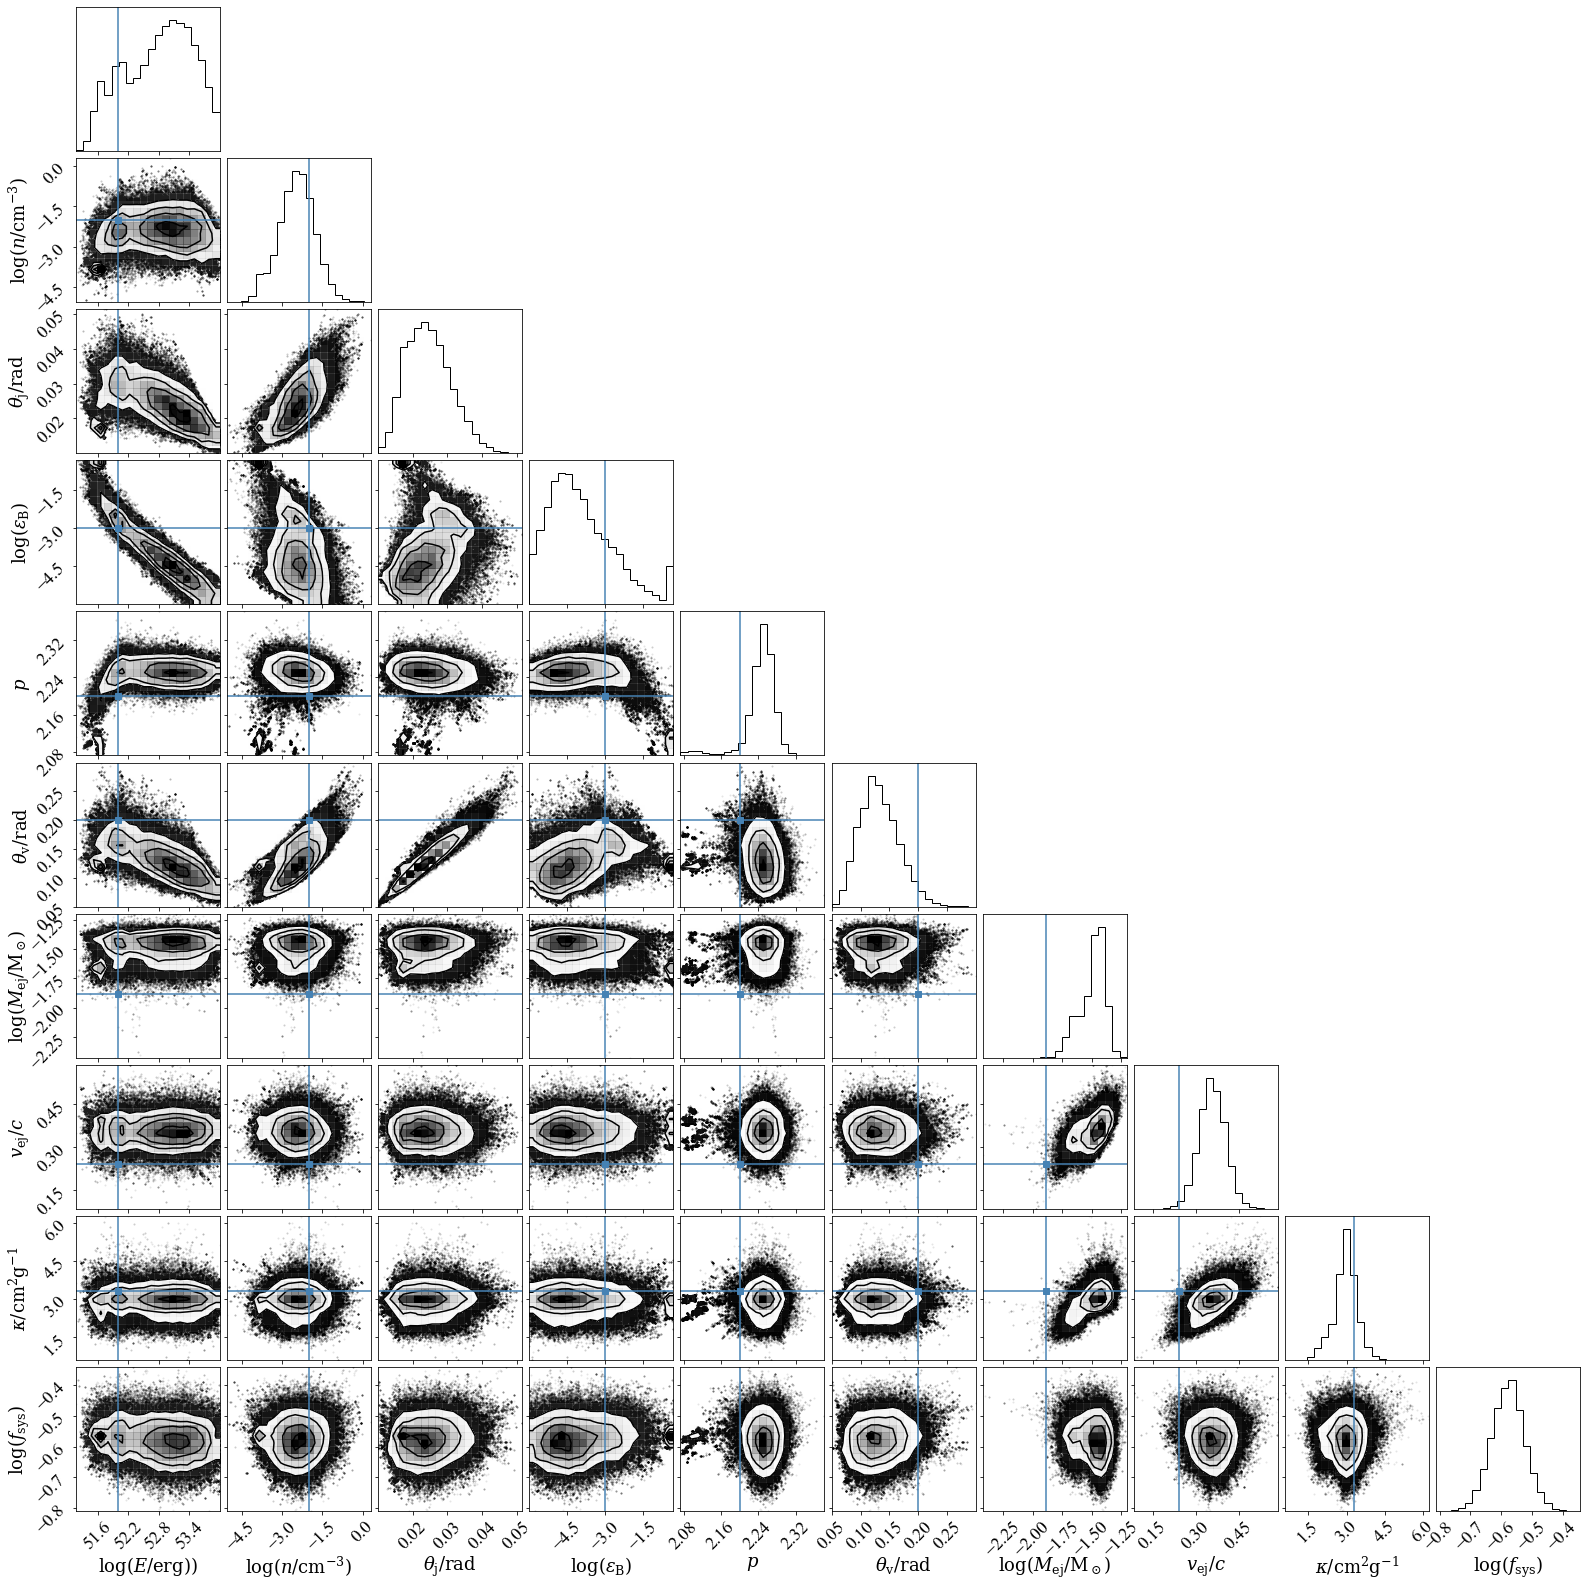

In [165]:
from corner import corner

flatchain = backend.get_chain(flat=True,discard=1500) # discard burn-in

labels = [r'$\log(E/\mathrm{erg}))$',r'$\log(n/\mathrm{cm^{-3}})$',r'$\theta_\mathrm{j}/\mathrm{rad}$',
         r'$\log(\epsilon_\mathrm{B})$',r'$p$',r'$\theta_\mathrm{v}/\mathrm{rad}$',
          r'$\log(M_\mathrm{ej}/\mathrm{M_\odot})$',r'$v_\mathrm{ej}/c$',r'$\kappa/\mathrm{cm^{2}g^{-1}}$',
         r'$\log(f_\mathrm{sys})$']

truths = [52.,-2,0.06,-3,2.2,0.2,np.log10(0.013),0.12*2,3.3,-10]

corner(flatchain,labels=labels,truths=truths);

The result is not bad, and for many of the parameters we recover values that are consistent with the true ones (i.e. those I injected when creating the mock dataset). The systematic biases in some of the parameters should not surprise us: I used a different (more detailed) set of models to create the data, and assumed a different jet structure (with a different *definition* of $\theta_\mathrm{j}$). This somewhat demonstrates how the use of rough models can yield quantitatively biased inference results, but still qualitatively correct. 

We can now use the samples to obtain our best fit model estimate along with the uncertainties:

In [166]:
means = np.mean(flatchain,axis=0)
variances = np.mean(flatchain**2-means[None,:]**2,axis=0)

In [167]:
for i in range(len(means)):
    print('{0} = {1:.3g} +/- {2:.3g}'.format(labels[i],means[i],variances[i]**0.5))

$\log(E/\mathrm{erg}))$ = 52.8 +/- 0.656
$\log(n/\mathrm{cm^{-3}})$ = -2.46 +/- 0.66
$\theta_\mathrm{j}/\mathrm{rad}$ = 0.0246 +/- 0.00635
$\log(\epsilon_\mathrm{B})$ = -3.95 +/- 1.28
$p$ = 2.24 +/- 0.035
$\theta_\mathrm{v}/\mathrm{rad}$ = 0.133 +/- 0.0337
$\log(M_\mathrm{ej}/\mathrm{M_\odot})$ = -1.49 +/- 0.108
$v_\mathrm{ej}/c$ = 0.357 +/- 0.0467
$\kappa/\mathrm{cm^{2}g^{-1}}$ = 2.96 +/- 0.469
$\log(f_\mathrm{sys})$ = -0.578 +/- 0.0549


One alternative is that of using percentiles:

In [168]:
p16,p50,p84 = np.percentile(flatchain,[16.,50.,84.],axis=0)

for i in range(len(means)):
    print('{0} = {1:.3g} +{2:.3g} -{3:.3g}'.format(labels[i],p50[i],p84[i]-p50[i],p50[i]-p16[i]))

$\log(E/\mathrm{erg}))$ = 52.9 +0.617 -0.866
$\log(n/\mathrm{cm^{-3}})$ = -2.45 +0.625 -0.664
$\theta_\mathrm{j}/\mathrm{rad}$ = 0.024 +0.00701 -0.0061
$\log(\epsilon_\mathrm{B})$ = -4.19 +1.53 -0.996
$p$ = 2.25 +0.0204 -0.0243
$\theta_\mathrm{v}/\mathrm{rad}$ = 0.129 +0.037 -0.0309
$\log(M_\mathrm{ej}/\mathrm{M_\odot})$ = -1.47 +0.0731 -0.149
$v_\mathrm{ej}/c$ = 0.356 +0.0453 -0.0445
$\kappa/\mathrm{cm^{2}g^{-1}}$ = 2.98 +0.39 -0.441
$\log(f_\mathrm{sys})$ = -0.577 +0.0526 -0.0551


In order to visualize the result, we also want to plot the model that corresponds to some samples of the posterior along with the data: 

/tmp/ipykernel_11589/2602178814.py:8: RuntimeWarning: overflow encountered in exp
  return K * (1.+z)**4/dL**2 * L/Teff**4 * nuobs**3/(np.exp((1.+z)*h*nuobs/kB/Teff)-1.)


Text(0, 0.5, 'Flux density [mJy]')

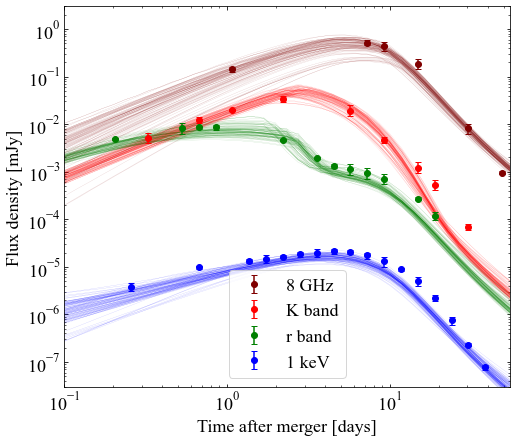

In [170]:
for j in range(100):
    x = flatchain[j*11]

    E = 10**x[0] # effectively log-uniform prior
    n = 10**x[1] # effectively log-uniform prior
    thj = x[2] 
    ee = 0.1
    eB = 10**x[3] # effectively log-uniform prior
    p = x[4]
    thv = x[5] 
    Mej = 10**x[6] # effectively log-uniform prior
    vej = x[7]
    k = x[8]

    
    # evaluate model
    Z = {'jetType':agpy.jet.Gaussian,'specType':0,'thetaObs':thv,'E0':E,'n0':n,
     'thetaCore':thj,'thetaWing':5*thj,'epsilon_e':ee,'epsilon_B':eB,'p':p,
     'xi_N':1.,'d_L':dL,'z':z,'spread':True}

    dFdnu_FS = agpy.fluxDensity(tmg.ravel(),numg.ravel(),**Z).reshape([len(num),len(tm)])
    dFdnu_KN = simplistic_kilonova(numg.ravel(),tmg.ravel(),Mej,vej,k).reshape([len(num),len(tm)])

    # plot it
    for i in range(len(num)):
        plt.plot(tm/86400.,dFdnu_KN[i]+dFdnu_FS[i],color=colors[i],ls='-',lw=0.2,alpha=0.3)
        #plt.plot(tm/86400.,dFdnu_KN[i],color=colors[i],ls='--')

    
    
    
# --------------- then plot the data on top -------------
    
# plot Radio flux densities
plt.errorbar(Radio['t_days'],Radio['Fnu_mJy'],yerr=Radio['Fnu_err_mJy'],marker='o',ls='None',capsize=3,label='8 GHz',color=colors[0])

# compute and plot NIR and Optical flux densities
Fnuo = 3631*1e3*10**(-IR['AB_mag']/2.5)
Fnuo_l = 3631*1e3*10**(-(IR['AB_mag']+IR['AB_mag_err'])/2.5)
Fnuo_h = 3631*1e3*10**(-(IR['AB_mag']-IR['AB_mag_err'])/2.5)
plt.errorbar(IR['t_days'],Fnuo,yerr=(Fnuo-Fnuo_l,Fnuo_h-Fnuo),marker='o',ls='None',capsize=3,label='K band',color=colors[1])

Fnuo = 3631*1e3*10**(-Opt['AB_mag']/2.5)
Fnuo_l = 3631*1e3*10**(-(Opt['AB_mag']+Opt['AB_mag_err'])/2.5)
Fnuo_h = 3631*1e3*10**(-(Opt['AB_mag']-Opt['AB_mag_err'])/2.5)
plt.errorbar(Opt['t_days'],Fnuo,yerr=(Fnuo-Fnuo_l,Fnuo_h-Fnuo),marker='o',ls='None',capsize=3,label='r band',color=colors[2])

# compute and plot X-ray flux densities
nua = 0.3*2.4e17
nub = 10.*2.4e17
nuX = 2.4e17
Fnuo = (2.-X['ph_index'])*X['Flux_cgs']/(nub**(2.-X['ph_index'])-nua**(2.-X['ph_index']))*nuX**(1.-X['ph_index'])*1e26
Fnuo_err = Fnuo*X['Flux_cgs_err']/X['Flux_cgs']

plt.errorbar(X['t_days'],Fnuo,yerr=Fnuo_err,marker='o',ls='None',capsize=3,label='1 keV',color=colors[3])

plt.loglog()

plt.xlim(1e-1,55)
plt.ylim(3e-8,3e0)

plt.legend()
plt.tick_params(which='both',direction='in',top=True,right=True)


plt.xlabel(r'Time after merger [days]')
plt.ylabel(r'Flux density [mJy]')


/tmp/ipykernel_11589/2602178814.py:8: RuntimeWarning: overflow encountered in exp
  return K * (1.+z)**4/dL**2 * L/Teff**4 * nuobs**3/(np.exp((1.+z)*h*nuobs/kB/Teff)-1.)


Text(0, 0.5, 'Flux density [mJy]')

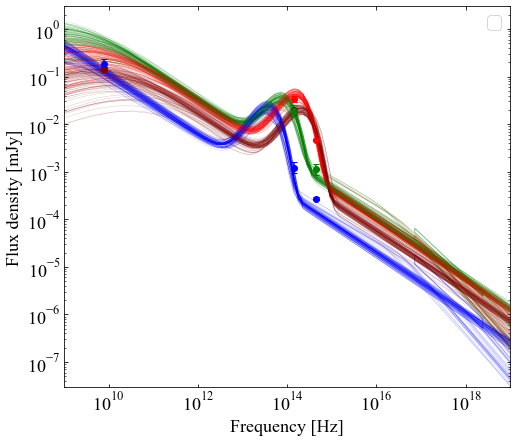

In [202]:
tm = np.array(t_spec)*86400
num = np.logspace(9,19,100)
tmg,numg = np.meshgrid(tm,num)

for j in range(100):
    x = flatchain[j*11]

    E = 10**x[0] # effectively log-uniform prior
    n = 10**x[1] # effectively log-uniform prior
    thj = x[2] 
    ee = 0.1
    eB = 10**x[3] # effectively log-uniform prior
    p = x[4]
    thv = x[5] 
    Mej = 10**x[6] # effectively log-uniform prior
    vej = x[7]
    k = x[8]

    
    # evaluate model
    Z = {'jetType':agpy.jet.Gaussian,'specType':0,'thetaObs':thv,'E0':E,'n0':n,
     'thetaCore':thj,'thetaWing':5*thj,'epsilon_e':ee,'epsilon_B':eB,'p':p,
     'xi_N':1.,'d_L':dL,'z':z,'spread':True}

    dFdnu_FS = agpy.fluxDensity(tmg.ravel(),numg.ravel(),**Z).reshape([len(num),len(tm)])
    dFdnu_KN = simplistic_kilonova(numg.ravel(),tmg.ravel(),Mej,vej,k).reshape([len(num),len(tm)])

    # plot it
    for i in range(len(t_spec)):
        plt.plot(num,dFdnu_FS[:,i]+dFdnu_KN[:,i],color=colors[i],lw=0.2,alpha=0.5)


# --------------- then plot the data on top -------------
for i in range(len(t_spec)):

    # plot Radio flux densities
    sel = np.abs(np.log(Radio['t_days']/(t_spec[i])))<dlogt[i]
    plt.errorbar(np.ones(len(Radio))[sel]*8e9,Radio.loc[sel,'Fnu_mJy'],yerr=Radio.loc[sel,'Fnu_err_mJy'],marker='o',ls='None',capsize=3,color=colors[i])

    # compute and plot NIR and Optical flux densities
    sel = np.abs(np.log(IR['t_days']/(t_spec[i])))<dlogt[i]
    Fnuo = 3631*1e3*10**(-IR.loc[sel,'AB_mag']/2.5)
    Fnuo_l = 3631*1e3*10**(-(IR.loc[sel,'AB_mag']+IR.loc[sel,'AB_mag_err'])/2.5)
    Fnuo_h = 3631*1e3*10**(-(IR.loc[sel,'AB_mag']-IR.loc[sel,'AB_mag_err'])/2.5)
    plt.errorbar(np.ones(len(Fnuo))*1.4e14,Fnuo,yerr=(Fnuo-Fnuo_l,Fnuo_h-Fnuo),marker='o',ls='None',capsize=3,color=colors[i])
    
    sel = np.abs(np.log(Opt['t_days']/(t_spec[i])))<dlogt[i]
    Fnuo = 3631*1e3*10**(-Opt.loc[sel,'AB_mag']/2.5)
    Fnuo_l = 3631*1e3*10**(-(Opt.loc[sel,'AB_mag']+Opt.loc[sel,'AB_mag_err'])/2.5)
    Fnuo_h = 3631*1e3*10**(-(Opt.loc[sel,'AB_mag']-Opt.loc[sel,'AB_mag_err'])/2.5)
    plt.errorbar(np.ones(len(Fnuo))*4.5e14,Fnuo,yerr=(Fnuo-Fnuo_l,Fnuo_h-Fnuo),marker='o',ls='None',capsize=3,color=colors[i])

    # compute and plot X-ray flux densities
    nua = 0.3*2.4e17
    nub = 10.*2.4e17
    nuX = np.logspace(np.log10(0.3),1.,30)*2.4e17
    nuX = nuX.reshape([30,1])
    sel = np.abs(np.log(X['t_days']/(t_spec[i])))<dlogt[i]
    if np.sum(sel)>0:
        Fnuo = (2.-X.loc[sel,'ph_index'])*X.loc[sel,'Flux_cgs']/(nub**(2.-X.loc[sel,'ph_index'])-nua**(2.-X.loc[sel,'ph_index']))*1e26
        Fnuo = Fnuo.values[:,None]*(nuX**(1.-X.loc[sel,'ph_index'].values))
        Fnuo_err = Fnuo*(X.loc[sel,'Flux_cgs_err'].values/X.loc[sel,'Flux_cgs'].values)
        
        for k in range(Fnuo.shape[1]):
            plt.fill_between(nuX[:,0],Fnuo[:,k]-Fnuo_err[:,k],Fnuo[:,k]+Fnuo_err[:,k],ls='-',edgecolor=colors[i],facecolor='None',alpha=0.5)

plt.loglog()

plt.xlim(1e9,1e19)
plt.ylim(3e-8,3e0)

plt.legend()
plt.tick_params(which='both',direction='in',top=True,right=True)


plt.xlabel(r'Frequency [Hz]')
plt.ylabel(r'Flux density [mJy]')